## Character Image Recognition - Math Recognition

In this notebook a model is created to make a prediction about which character the image is supposed to display

In [1]:
print("start")

start


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import os

!pip install rarfile
import rarfile

from sklearn.model_selection import train_test_split

In [3]:
!apt-get install unrar -y
!unrar x /kaggle/input/handwrittenmathsymbols/data.rar handwritten_data/ > /dev/null




The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 0s (1295 kB/s)
Selecting previously unselected package unrar.
(Reading database ... 115958 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
Unpacking unrar (1:5.6.6-2build1) ...
Setting up unrar (1:5.6.6-2build1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unrar-nonfree.1.gz (of link group unrar) doesn't exist
Processing triggers for man-db (2.9.1-1) ...


In [4]:
labels = os.listdir("handwritten_data/extracted_images")
print(labels)
amt_labels = len(labels)

['v', 'lambda', '6', 'A', ',', 'pm', '5', '[', '0', 'k', 'lt', '8', 'exists', 'times', 'q', 'j', 'div', 'f', 'H', 'ascii_124', '4', 'sum', 'y', 'gamma', 'mu', 'neq', 'N', 'theta', ')', 'o', '!', 'R', 'ldots', 'prime', 'pi', 'd', '{', 'lim', 'e', 'sin', 'cos', 'sqrt', '-', '9', 'forall', 'C', 'rightarrow', 'alpha', '}', 'X', '=', 'leq', '2', 'tan', 'p', 'T', 'l', 'geq', 'u', 'w', 'i', ']', 'b', 'S', '7', 'forward_slash', '1', 'in', '+', 'beta', '3', 'log', 'int', 'phi', '(', 'z', 'sigma', 'Delta', 'gt', 'G', 'M', 'infty']


In [5]:
from scipy.ndimage import gaussian_filter

def convert_to_grayscale(array):
    # shape (x, y, 3) --> (x, y)
    return np.dot(array[...,:3], [0.2989, 0.5870, 0.1140])

def apply_gaussian_filter(image):
    return gaussian_filter(image, sigma=1)

def crop_to_roi(image):
    rows = np.any(image > 0, axis=1)
    cols = np.any(image > 0, axis=0)
    row_start, row_end = np.where(rows)[0][[0, -1]]
    col_start, col_end = np.where(cols)[0][[0, -1]]
    return image[row_start:row_end+1, col_start:col_end+1]

def center_image(image, target_size=28, border=2):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate the new dimensions
    if aspect_ratio > 1:  # Wider than tall
        new_w = target_size[0] - 2 * border
        new_h = int(new_w / aspect_ratio)
    else:  # Taller than wide
        new_h = target_size[1] - 2 * border
        new_w = int(new_h * aspect_ratio)

    image = np.expand_dims(image, axis=-1)  # Add channel axis (shape -> (h, w, 1) )
    
    # Resize while preserving the aspect ratio
    image_resized = tf.image.resize(image, (new_h, new_w)).numpy()

    image_resized = np.squeeze(image_resized, axis=-1) # remove channel axis again
    
    # Create the centered canvas
    canvas = np.zeros(target_size, dtype=image.dtype)
    row_start = (target_size[0] - new_h) // 2
    col_start = (target_size[1] - new_w) // 2
    canvas[row_start:row_start+new_h, col_start:col_start+new_w] = image_resized

    return canvas


def normalize_image(image):
    return (image / np.max(image))


def preprocess_image(image, target_size=(28, 28)):
    if len(image.shape) == 3 and image.shape[2] >= 3:
        image = convert_to_grayscale(image)
    elif len(image.shape) == 3 and image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)
        
    image = apply_gaussian_filter(image)
    image = crop_to_roi(image)
    image = center_image(image, target_size=target_size)
    image = normalize_image(image)
    return image.astype(np.float32)

In [6]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size=(128, 128), inverse=False, grayscale=False):
    """
    Load an image and make it a numpy array.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array
    img_array = image.img_to_array(img)

    if grayscale:
        # Convert RGB to Grayscale
        img_array = tf.image.rgb_to_grayscale(img_array)

    # normalize to [0, 1]
    img_array = img_array / np.max(img_array)

    if inverse:
        img_array = 1 - img_array
    
    # Add a batch dimension (because the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [7]:
def load_and_preprocess_images_from_dir(dir_path, target_size=(28, 28), inverse=False, grayscale=False):
    X = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue
            
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)

    X = np.array(X)
    return X

In [8]:
def load_and_preprocess_all_image_classes_from_dir(dir_path, target_size=(28, 28), inverse=False, grayscale=False):
    X = []
    y = []
    for img in sorted(os.listdir(dir_path)):
        img_path = os.path.join(dir_path, img)
        if not os.path.isfile(img_path):
            continue

        i = int(img[3:6]) - 1 # index starts at 0
        
        img_array = load_and_preprocess_image(img_path, target_size=target_size, inverse=inverse, grayscale=grayscale)
        img_array = np.squeeze(img_array, axis=0)
        X.append(img_array)
        y.append(i)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [9]:
dir_path = "handwritten_data/extracted_images"

validation_frac = 0.2
batch_size = 256

ds_train = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=[96, 96],
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="training",
    validation_split=validation_frac,
    seed=0
)

label_map = ds_train.class_names

ds_valid = image_dataset_from_directory(
    dir_path,
    labels='inferred',
    label_mode = 'categorical',
    image_size=[96, 96],
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    subset="validation",
    validation_split=validation_frac,
    seed=0
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    label = tf.cast(label, tf.float16)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.
Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [10]:
def grayscale_image(image, label):
    # Convert RGB to grayscale (shape changes from (128, 128, 3) to (128, 128, 1))
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

ds_train = ds_train.map(grayscale_image)
ds_valid = ds_valid.map(grayscale_image)
ds_train

<_MapDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float16, name=None), TensorSpec(shape=(None, 82), dtype=tf.float16, name=None))>

In [11]:
model = keras.Sequential([
    layers.InputLayer(shape=[96, 96, 1]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer='l2'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.GlobalAveragePooling2D(),

    # Head
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    layers.Dropout(0.5),
    layers.Dense(amt_labels, activation='softmax'),
])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import shutil

train_model = False

weights_path = "/kaggle/input/math-handwritten-model/keras/default/1/char_recog_model_math.weights.h5"
if os.path.isfile(weights_path) and not train_model:
    model.load_weights(weights_path)
    history = None

else:
    early_stopping = EarlyStopping(min_delta=0.001, patience=6, restore_best_weights=True)
    
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=50,
        callbacks=[early_stopping]
    )

    model.save_weights("char_recog_model.weights.h5")
    shutil.move("char_recog_model.weights.h5", "/kaggle/working/char_recog_model.weights.h5")

In [13]:
import pandas as pd
if history is not None:
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [14]:
def plot_n_images(X, y, n=10, row_spacing=0.5):
    plt.figure(figsize=(10, 5))
    # Show the first n images if available, otherwise show all images
    for i in range(min(n, X.shape[0], y.shape[0])):  
        plt.subplot(n // 5 + 1, 5, i+1)
        plt.imshow(X[i], cmap='gray')  # Assuming 28x28 images
        plt.title(label_map[y[i]])
        plt.axis('off')

    plt.subplots_adjust(hspace=row_spacing)
    plt.show()

### Validation data same dataset accuracy

In [15]:
if history is not None:
    loss, accuracy = model.evaluate(ds_valid)
    print(f"Loss: {loss}, accuracy: {accuracy}")

In [16]:
dir_path = "/kaggle/input/letters-and-digits/Images characters/"

dir_path_handwritten_upper = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Uppercase"
dir_path_handwritten_lower = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Lowercase"
dir_path_handwritten_math_simple = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Simple"
dir_path_handwritten_math_complex = "/kaggle/input/letters-and-digits/Images characters/Handwritten/Math - Complex"

dir_path_typed_upper = "/kaggle/input/letters-and-digits/Images characters/Typed/Uppercase"
dir_path_typed_lower = "/kaggle/input/letters-and-digits/Images characters/Typed/Lowercase"
dir_path_typed_latex_math = "/kaggle/input/letters-and-digits/Images characters/Typed/Latex Math"

img_path_zero = "/kaggle/input/letters-and-digits/Images characters/zero.png"
img_path_drawn_zero = "/kaggle/input/letters-and-digits/Images characters/drawn_zero.png"
img_path_drawn_M_close = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_close.png"
img_path_drawn_M_far = "/kaggle/input/letters-and-digits/Images characters/M_handwritten_far.png"

(20, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
(20, 128, 128, 1) (20,)


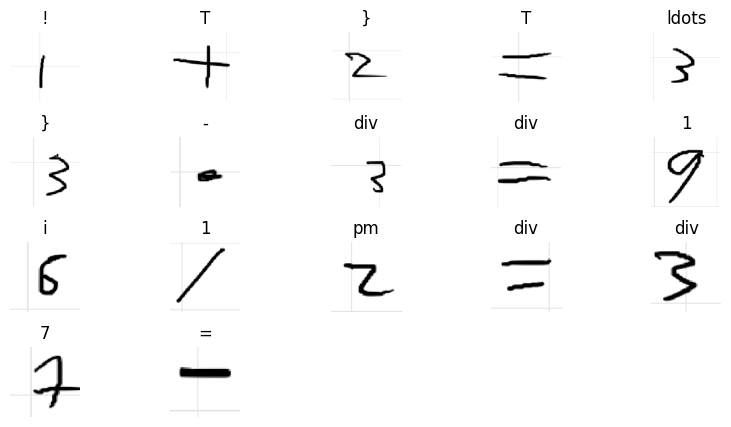

In [17]:
path = dir_path_handwritten_math_simple
processed_images = load_and_preprocess_images_from_dir(path, target_size=(128, 128), grayscale=True)
# processed_image = np.array([X_test[2]])

print(processed_images.shape)

# Make the prediction
predictions = model.predict(processed_images)

# For multi-class classification (e.g., 62 classes):
# Get the index of the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

print(processed_images.shape, predicted_classes.shape)
plot_n_images(processed_images, predicted_classes, n=17, row_spacing=0.5)